# Predicting Order Days in a Month — AB InBev Case Study

## Context

AB InBev's logistics team aims to optimize delivery resource allocation throughout the month by anticipating **the specific days on which each customer will place orders**. The prediction must be dynamic—meaning the model should be able to **estimate, at any given point in the month, how many order days remain** for each customer.

Let’s consider a real example from the dataset:

```json
{
  "account_id": "BR_09607801000194",
  "order_date": ["2021-01-04", "2021-01-04", "2021-01-25", "2021-01-25", "2021-01-25"]
}
```

In this case, the customer placed orders on two distinct days in January 2021: the 4th and the 25th. Therefore, the customer had **2 order days in the month**. We want the model to predict that:

* Before January 4th → **2 order days remaining**
* After January 4th and before January 25th → **1 order day remaining**
* After January 25th → **0 order days remaining**

### Objective

Build a predictive model capable of estimating, **for each customer and for every date in August 2022**, **how many order days remain until the end of the month**.

### Data Sources

* **`historical_orders.parquet`**
  Contains historical order records used as **training data** to learn monthly purchasing behavior.

* **`august_with_missing_order_days.parquet`**
  Contains partial order records from August 2022 and serves as the **main test set**.

* **`august_total_sales.parquet`**
  Provides total predicted sales for August. This can be used as an auxiliary variable (assume the forecast is accurate).

### Target Variable: `order_days`

The `order_days` variable was created as the **target for prediction**. It represents:

> For each customer's record on date `d`, the number of **unique remaining order days** in the month starting from `d` (inclusive).

For example, if a customer placed orders on August 5th, 10th, and 20th:

* Before the 5th → `order_days = 3`
* After the 5th and before the 10th → `order_days = 2`
* After the 20th → `order_days = 0`

**Developed by:** *Lucas Sousa*

## PySpark Setup and Configuration and libraries

In [1]:
# Installing dependencies
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
!tar xf spark-3.4.4-bin-hadoop3.tgz
!pip install -q findspark seaborn matplotlib

In [2]:
# Environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3/"

# Initialize Spark
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('ab_inbev').master("local[*]").getOrCreate()

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import Window
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import shapiro, normaltest, kstest, poisson, geom, boxcox
import pandas as pd


##  Data Loading

In [4]:
# Load Parquet files
august_data = spark.read.format('parquet').load('/content/august_with_missing_order_days.parquet')
historical_data = spark.read.format('parquet').load('/content/historical_orders.parquet')
august_sales = spark.read.format('parquet').load('/content/august_total_sales.parquet')

## Date Preprocessing

In [5]:
from pyspark.sql.functions import to_date, date_format, col

historical_data = historical_data.withColumn("order_date", to_date(col("order_date")))
historical_data = historical_data.withColumn("year_month", date_format(col("order_date"), "yyyy-MM"))

## Initial Data Exploration

In [16]:
from pyspark.sql.functions import countDistinct, min, max

# Dataset overview
print("-- Historical Data:")
historical_data.printSchema()
historical_data.show(2, truncate=False)
print(f"Unique customers (historical): {historical_data.select(countDistinct('account_id')).collect()[0][0]}")
print(f"Historical period: {historical_data.select(min('order_date'), max('order_date')).collect()[0]}")

print("-- August Data:")
august_data.printSchema()
august_data.show(2, truncate=False)
print(f"Unique customers in August: {august_data.select(countDistinct('account_id')).collect()[0][0]}")

print("-- Forecast Data:")
august_sales.printSchema()
august_sales.show(2, truncate=False)
print(f"Customers for prediction: {august_sales.count()}")

-- Historical Data:
root
 |-- account_id: string (nullable = true)
 |-- order_date: date (nullable = true)
 |-- transaction_amount: double (nullable = true)
 |-- __index_level_0__: long (nullable = true)
 |-- year_month: string (nullable = true)

+-----------------+----------+------------------+-----------------+----------+
|account_id       |order_date|transaction_amount|__index_level_0__|year_month|
+-----------------+----------+------------------+-----------------+----------+
|BR_09607801000194|2021-08-28|11011.2           |0                |2021-08   |
|BR_09607801000194|2021-08-28|13764.0           |1                |2021-08   |
+-----------------+----------+------------------+-----------------+----------+
only showing top 2 rows

Unique customers (historical): 47899
Historical period: Row(min(order_date)=datetime.date(2021, 1, 2), max(order_date)=datetime.date(2022, 7, 31))
-- August Data:
root
 |-- account_id: string (nullable = true)
 |-- total_transaction_amount_august: double

## Order Days Calculation Function

In [6]:
from pyspark.sql import functions as F

def order_days(df):
    df = df.withColumn("order_date", to_date("order_date"))
    unique_days = df.select("account_id", "year_month", F.col("order_date").alias("order_date")).distinct()

    a = unique_days.alias("a")
    b = unique_days.alias("b")

    join_condition = (
        (col("a.account_id") == col("b.account_id")) &
        (col("a.year_month") == col("b.year_month")) &
        (col("b.order_date") >= col("a.order_date"))
    )

    joined = a.join(b, on=join_condition, how="left")

    order_days_df = joined.groupBy("a.account_id", "a.year_month", "a.order_date") \
        .agg(F.countDistinct("b.order_date").alias("order_days")) \
        .withColumnRenamed("order_date", "order_date")

    return df.join(order_days_df, on=["account_id", "year_month", "order_date"], how="left")

historical_data = order_days(historical_data)

### calculation verification

Checking if order_days is correct for a random account_id

In [18]:
# Contagem de dias únicos para um account_id
unique_order_dates_count = historical_data.filter(
    (col("account_id") == "BR_09607801000194") &
    (col("order_date") >= "2021-01-01") &
    (col("order_date") <= "2021-01-31")
).selectExpr("count(distinct order_date)").collect()[0][0]
print(f"Número de order_date únicos: {unique_order_dates_count}")

Número de order_date únicos: 11


In [19]:
historical_data.filter(col("account_id") == "BR_09607801000194") \
               .orderBy("order_date").show(n=100, truncate=False)

+-----------------+----------+----------+------------------+-----------------+----------+
|account_id       |year_month|order_date|transaction_amount|__index_level_0__|order_days|
+-----------------+----------+----------+------------------+-----------------+----------+
|BR_09607801000194|2021-01   |2021-01-02|7645.28           |660009           |11        |
|BR_09607801000194|2021-01   |2021-01-02|1556.0            |660022           |11        |
|BR_09607801000194|2021-01   |2021-01-02|618.0             |660124           |11        |
|BR_09607801000194|2021-01   |2021-01-02|3436.2            |660125           |11        |
|BR_09607801000194|2021-01   |2021-01-02|309.0             |660126           |11        |
|BR_09607801000194|2021-01   |2021-01-02|4828.32           |660127           |11        |
|BR_09607801000194|2021-01   |2021-01-02|4828.32           |660133           |11        |
|BR_09607801000194|2021-01   |2021-01-02|3436.2            |660134           |11        |
|BR_096078

## Feature Engineering

In [7]:
# Feature Engineering - Temporal Variables
historical_data = historical_data.withColumn("day_of_month", dayofmonth("order_date")) \
    .withColumn("day_of_week", dayofweek("order_date")) \
    .withColumn("is_weekend", when(col("day_of_week").isin(1, 7), 1).otherwise(0)) \
    .withColumn("days_left_in_month", datediff(last_day("order_date"), col("order_date"))) \
    .withColumn("month_num", month("order_date")) \
    .withColumn("year_num", year("order_date")) \
    .withColumn("quarter", quarter("order_date"))

# Aggregations by customer and month
agg_window = Window.partitionBy("account_id", "year_month")
historical_data = historical_data.withColumn("total_transactions_in_month", sum("transaction_amount").over(agg_window)) \
    .withColumn("average_transaction_value", avg("transaction_amount").over(agg_window)) \
    .withColumn("std_transaction_value", stddev("transaction_amount").over(agg_window))

# Cumulative by date
date_order_window = Window.partitionBy("account_id", "year_month").orderBy("order_date") \
    .rowsBetween(Window.unboundedPreceding, Window.currentRow)

historical_data = historical_data.withColumn("cumulative_transaction_amount", sum("transaction_amount").over(date_order_window)) \
    .withColumn("percent_cumulative_amount", col("cumulative_transaction_amount") / col("total_transactions_in_month"))

# Daily transaction count
daily_window = Window.partitionBy("account_id", "year_month", "order_date")
historical_data = historical_data.withColumn("transaction_count_in_day", count("*").over(daily_window))

## Exploratory Data Analysis (with pandas + seaborn)

We use a sample to perform EDA and model prototyping due to limited computational resources.

In [21]:
# Sampling (Discomment to stratify by account Id or any other feature.)
#fractions = historical_data.select("account_id").distinct().rdd.map(lambda x: (x[0], 0.1)).collectAsMap()
#sample = historical_data.sampleBy("account_id", fractions, seed=42)
#sample_historical_df = sample.toPandas()

In [8]:
# Sampling
sample = historical_data.sample(withReplacement=False, fraction=0.03, seed=42) #I'm using 3% because I don't have computational power enough
sample_historical_df = sample.toPandas()

print(f"Sample size: {len(sample_historical_df)} records")

Sample size: 257746 records


### Graphs

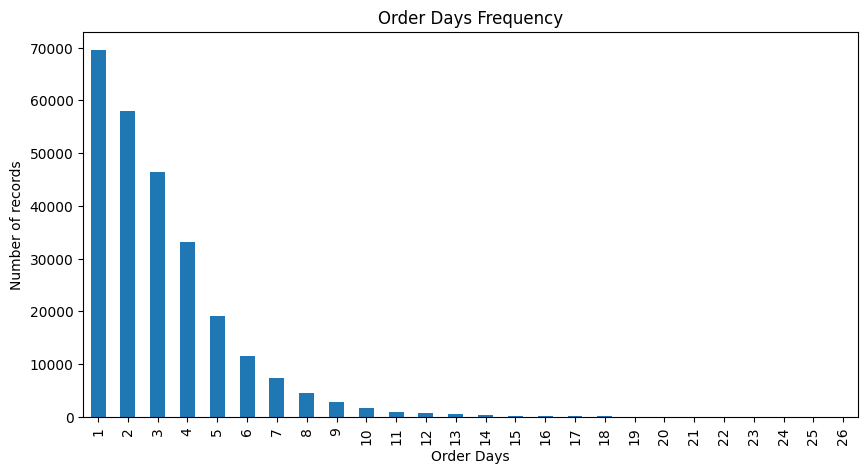

In [23]:
# Distribution order_days
order_days_counts = sample_historical_df['order_days'].value_counts().sort_index()
plt.figure(figsize=(10, 5))
order_days_counts.plot(kind='bar')
plt.title('Order Days Frequency')
plt.xlabel('Order Days')
plt.ylabel('Number of records')
plt.show()

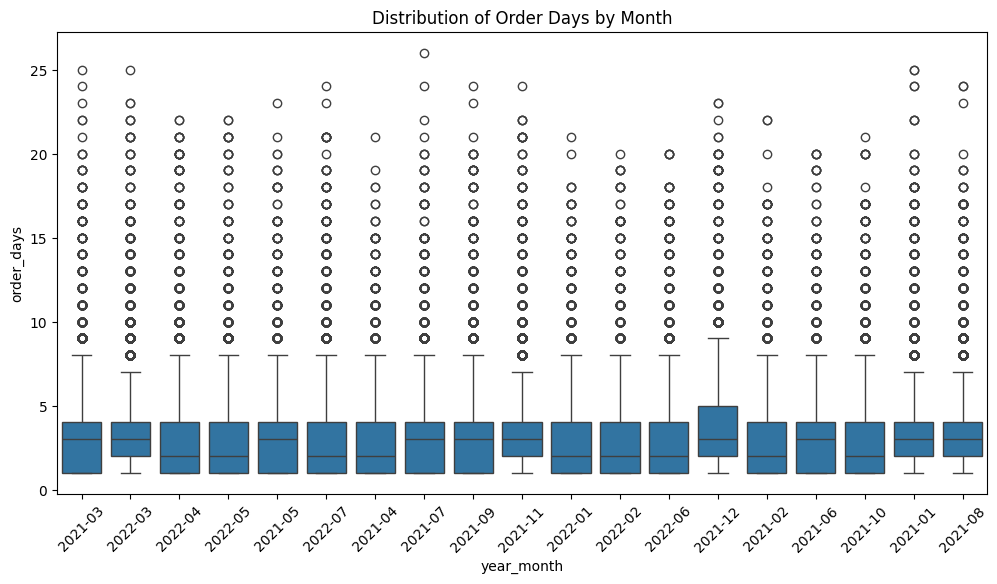

In [24]:
# Boxplot per month
plt.figure(figsize=(12, 6))
sns.boxplot(x='year_month', y='order_days', data=sample_historical_df)
plt.xticks(rotation=45)
plt.title('Distribution of Order Days by Month')
plt.show()

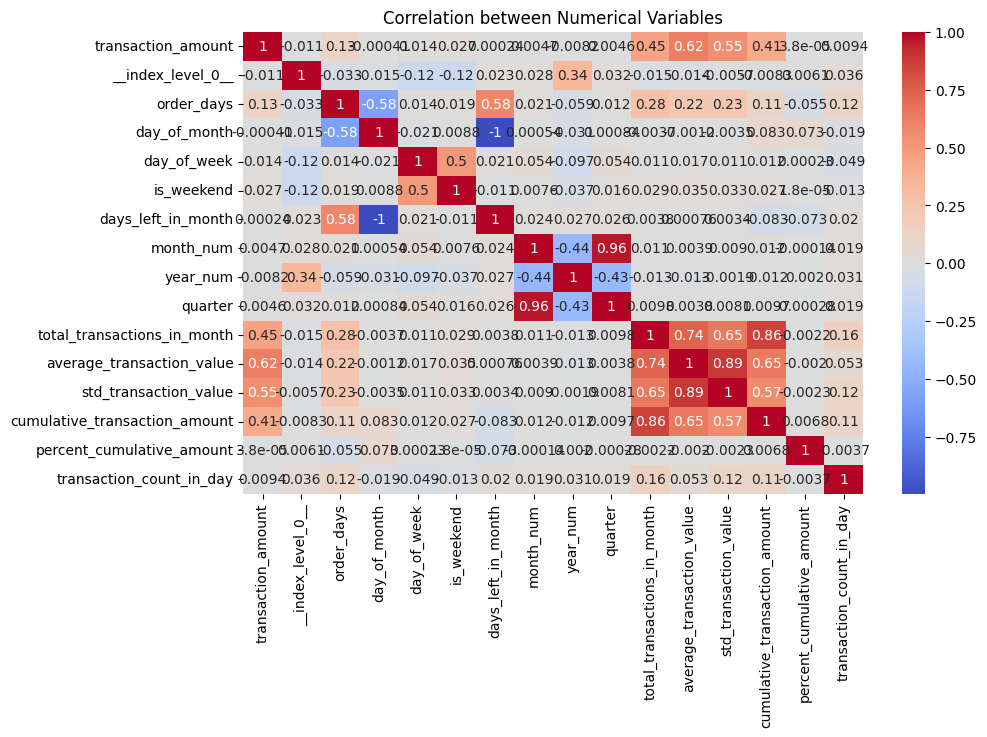

In [25]:
# Features correlations
plt.figure(figsize=(10, 6))
sns.heatmap(sample_historical_df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation between Numerical Variables')
plt.show()

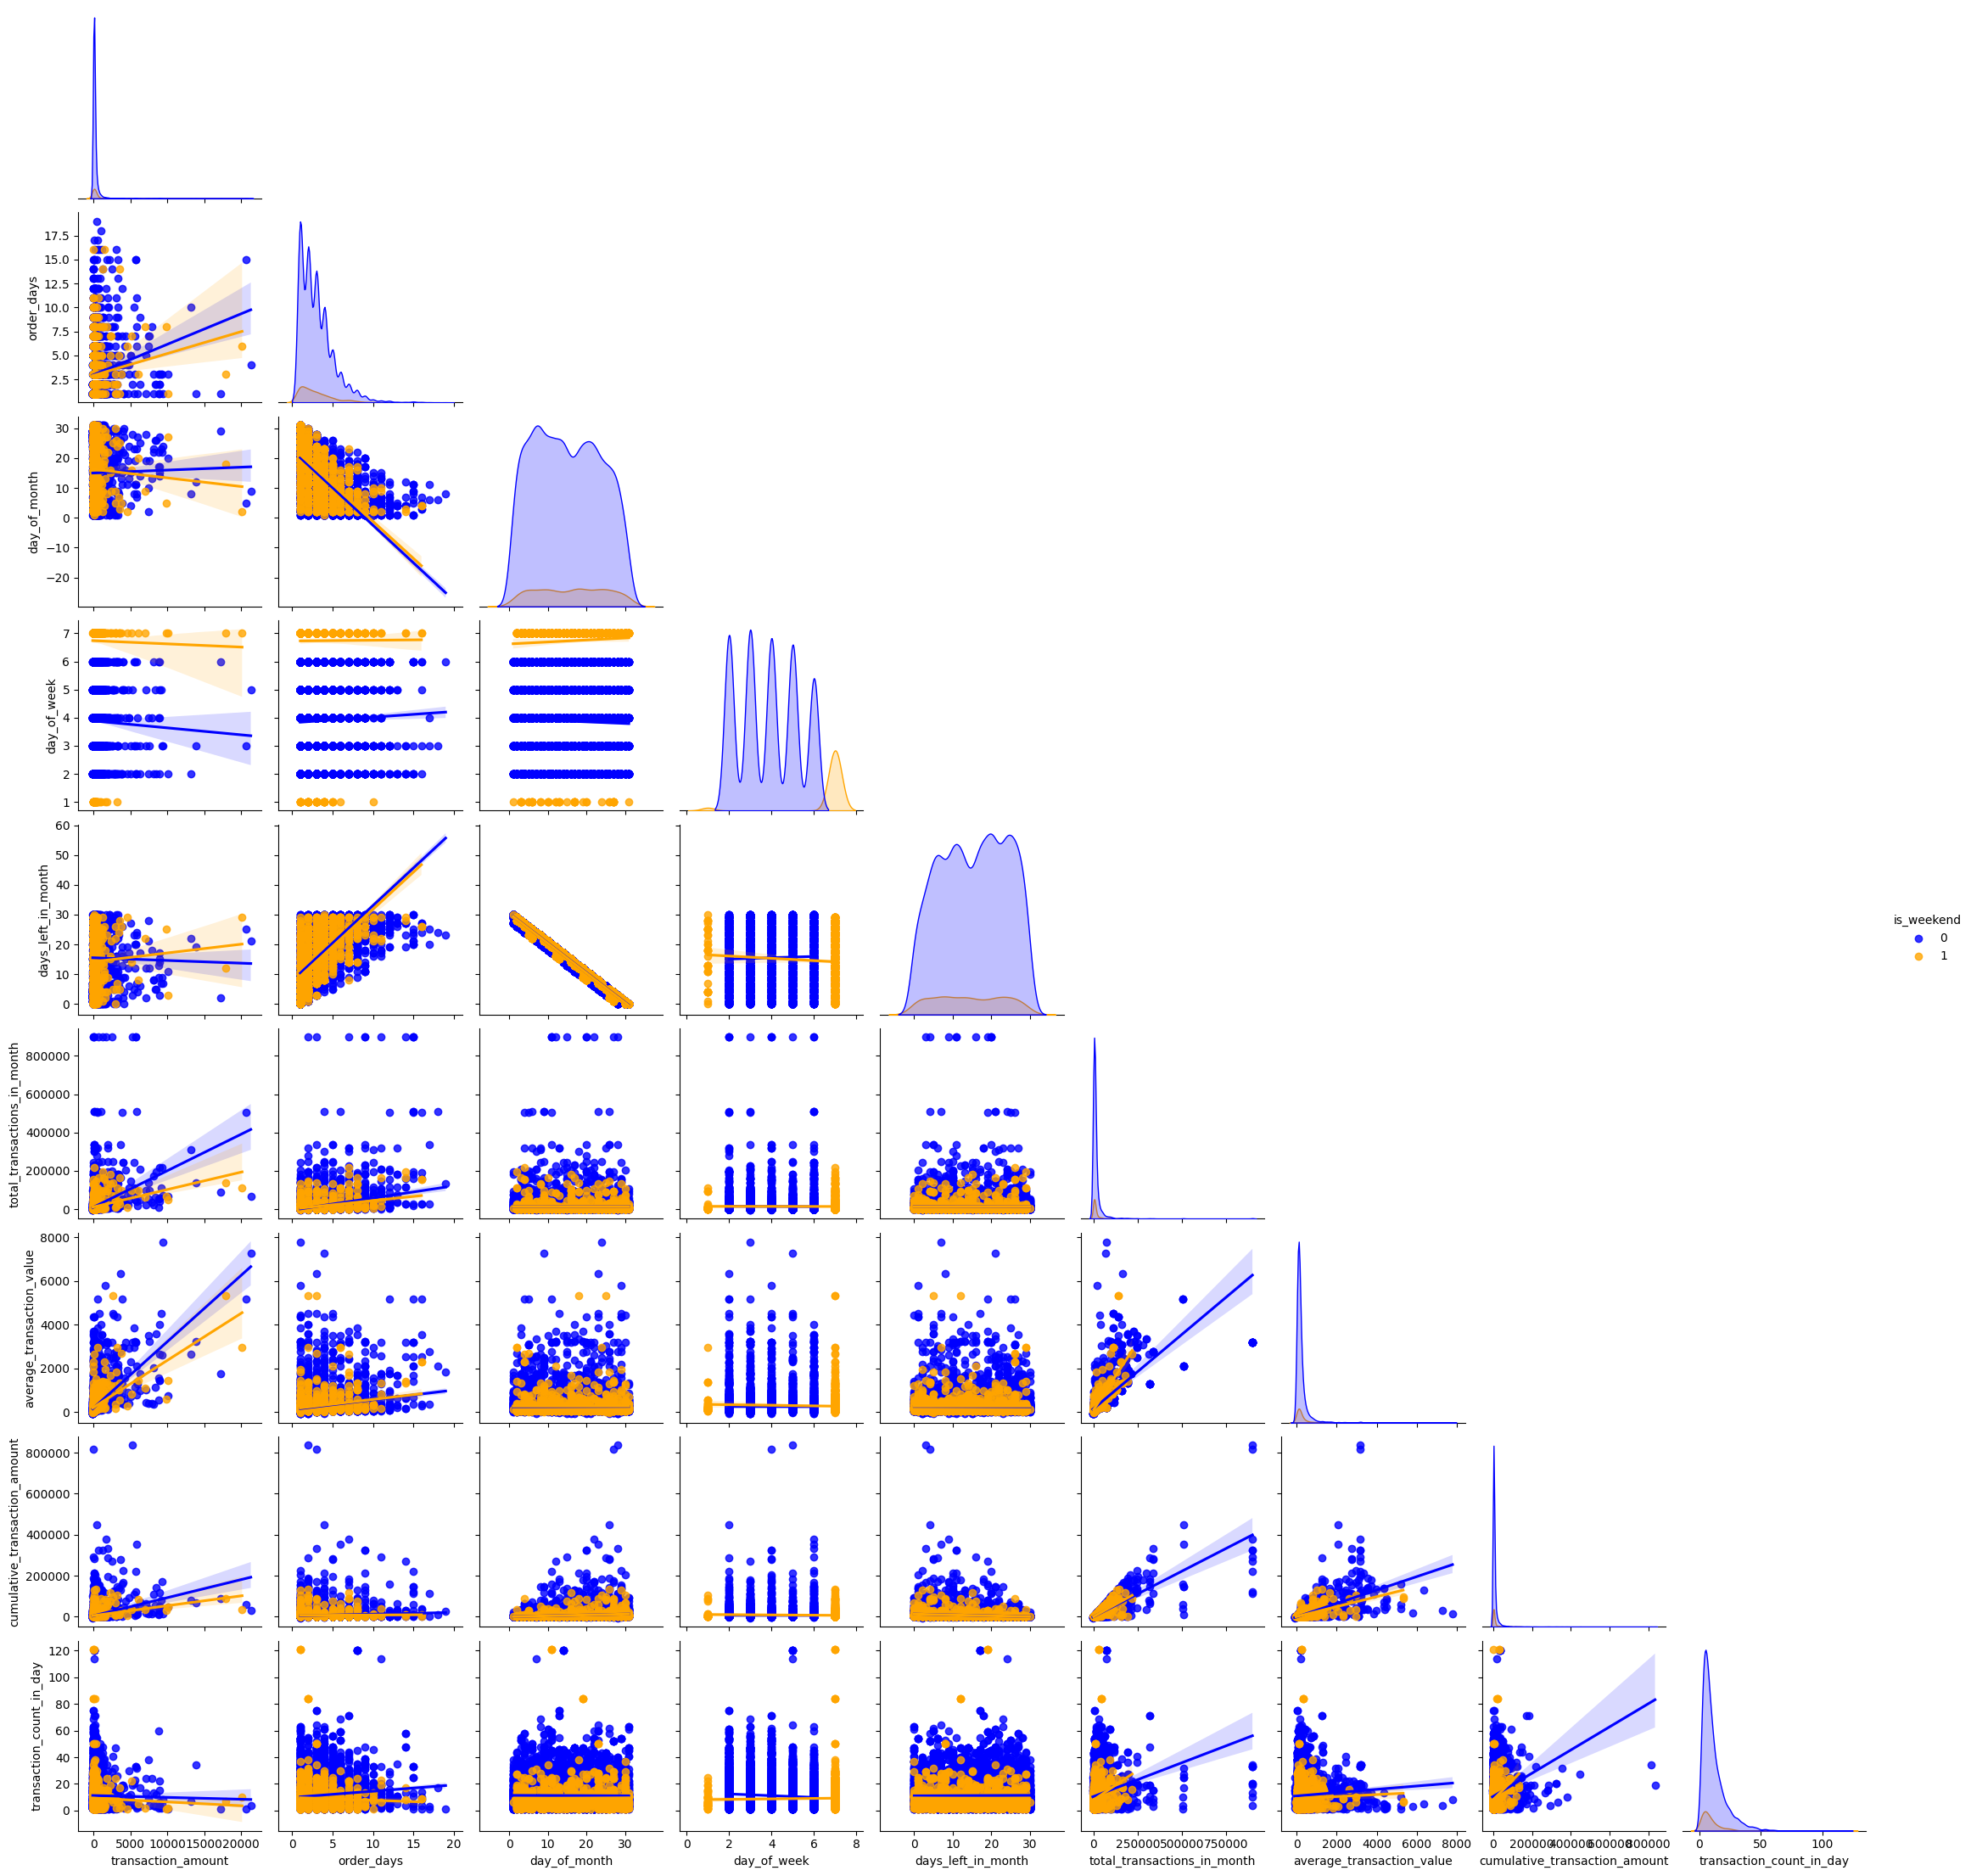

In [26]:
# Pairplot
sns.pairplot(sample_historical_df.head(10000),
             vars=['transaction_amount', 'order_days', 'day_of_month', 'day_of_week',
                   'days_left_in_month', 'total_transactions_in_month', 'average_transaction_value',
                   'cumulative_transaction_amount', 'transaction_count_in_day'],
             kind='reg', hue='is_weekend',
             palette={0: 'blue', 1: 'orange'}, corner=True)

#### investigating the distribuition of order_days

In [27]:
# Sample for statistical tests (20% like your code)
sample_order_days = historical_data.sample(withReplacement=False, fraction=0.2, seed=42).limit(2000000).toPandas()["order_days"]

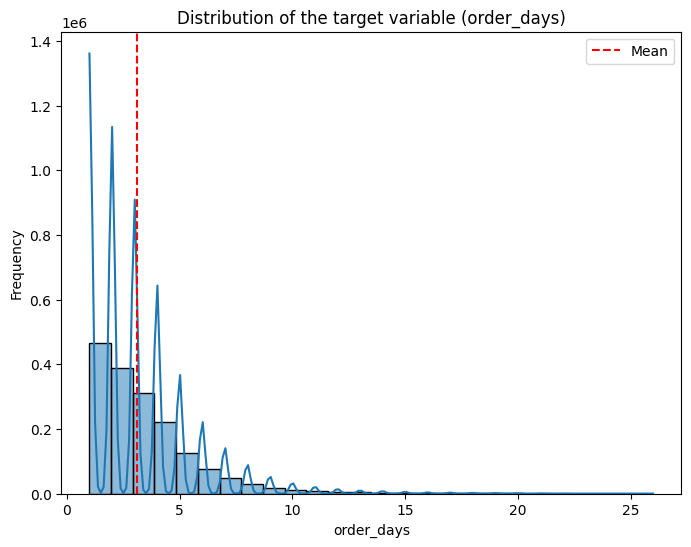

In [29]:
# Histogram for visual inspection
plt.figure(figsize=(8, 6))
sns.histplot(sample_order_days, kde=True, bins=26)
plt.title('Distribution of the target variable (order_days)')
plt.xlabel('order_days')
plt.ylabel('Frequency')
plt.axvline(sample_order_days.mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()

Looks like a poisson distribuition or Negative binomial distribution

In [30]:
from scipy.stats import nbinom, lognorm


# Shapiro-Wilk Test for normality
shapiro_stat, shapiro_p = shapiro(sample_order_days.sample(5000, random_state=42) if len(sample_order_days) > 5000 else sample_order_days)
print(f"Shapiro-Wilk Test: statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# Kolmogorov-Smirnov Test for Poisson distribution
lambda_poisson = sample_order_days.mean()
ks_stat_poisson, ks_p_poisson = kstest(sample_order_days, cdf='poisson', args=(lambda_poisson,))
print(f"Kolmogorov-Smirnov Test for Poisson: statistic = {ks_stat_poisson:.4f}, p-value = {ks_p_poisson:.4f}")

# Kolmogorov-Smirnov Test for Geometric distribution
p_geom = 1 / sample_order_days.mean()
ks_stat_geom, ks_p_geom = kstest(sample_order_days, cdf='geom', args=(p_geom,))
print(f"Kolmogorov-Smirnov Test for Geometric: statistic = {ks_stat_geom:.4f}, p-value = {ks_p_geom:.4f}")

# Interpretation
if shapiro_p < 0.05:
    print("The target variable **does not** follow a normal distribution.")
if ks_p_poisson < 0.05:
    print("The target variable **does not** follow a Poisson distribution.")
if ks_p_geom < 0.05:
    print("The target variable **does not** follow a geometric distribution.")

Shapiro-Wilk Test: statistic = 0.7938, p-value = 0.0000
Kolmogorov-Smirnov Test for Poisson: statistic = 0.1839, p-value = 0.0000
Kolmogorov-Smirnov Test for Geometric: statistic = 0.3220, p-value = 0.0000
The target variable **does not** follow a normal distribution.
The target variable **does not** follow a Poisson distribution.
The target variable **does not** follow a geometric distribution.


In [36]:
from scipy.stats import nbinom, lognorm

# Shapiro-Wilk Test for normality
shapiro_stat, shapiro_p = shapiro(sample_order_days.sample(5000, random_state=42) if len(sample_order_days) > 5000 else sample_order_days)
print(f"Shapiro-Wilk Test: statistic = {shapiro_stat:.4f}, p-value = {shapiro_p:.4f}")

# Kolmogorov-Smirnov Test for Poisson distribution
lambda_poisson = sample_order_days.mean()
ks_stat_poisson, ks_p_poisson = kstest(sample_order_days, cdf='poisson', args=(lambda_poisson,))
print(f"Kolmogorov-Smirnov Test for Poisson: statistic = {ks_stat_poisson:.4f}, p-value = {ks_p_poisson:.4f}")

# Kolmogorov-Smirnov Test for Geometric distribution
p_geom = 1 / sample_order_days.mean()
ks_stat_geom, ks_p_geom = kstest(sample_order_days, cdf='geom', args=(p_geom,))
print(f"Kolmogorov-Smirnov Test for Geometric: statistic = {ks_stat_geom:.4f}, p-value = {ks_p_geom:.4f}")

# Kolmogorov-Smirnov Test for Negative Binomial distribution
mean_val = sample_order_days.mean()
var_val = sample_order_days.var()
if var_val > mean_val:  # Check for overdispersion
    p_nb = mean_val / var_val
    n_nb = mean_val**2 / (var_val - mean_val)
    ks_stat_nbinom, ks_p_nbinom = kstest(sample_order_days, cdf='nbinom', args=(n_nb, p_nb))
    print(f"Kolmogorov-Smirnov Test for Negative Binomial: statistic = {ks_stat_nbinom:.4f}, p-value = {ks_p_nbinom:.4f}")
else:
    print("No overdispersion detected - Negative Binomial test skipped")
    ks_p_nbinom = 1.0  # Set to not reject for interpretation

# Kolmogorov-Smirnov Test for Log-Normal distribution (discrete approximation)
sample_log = sample_order_days[sample_order_days > 0] + 1  # Add 1 to avoid log(0)
if len(sample_log) > 0:
    params_lognorm = lognorm.fit(sample_log)
    ks_stat_lognorm, ks_p_lognorm = kstest(sample_log, cdf='lognorm', args=params_lognorm)
    print(f"Kolmogorov-Smirnov Test for Log-Normal: statistic = {ks_stat_lognorm:.4f}, p-value = {ks_p_lognorm:.4f}")
else:
    ks_p_lognorm = 1.0

# Kolmogorov-Smirnov Test for Exponential distribution (continuous approximation)
rate_exp = 1 / sample_order_days.mean()
ks_stat_expon, ks_p_expon = kstest(sample_order_days, cdf='expon', args=(0, 1/rate_exp))
print(f"Kolmogorov-Smirnov Test for Exponential: statistic = {ks_stat_expon:.4f}, p-value = {ks_p_expon:.4f}")

# Summary of best fitting distributions
distributions = {
    'Normal': shapiro_p,
    'Poisson': ks_p_poisson,
    'Geometric': ks_p_geom,
    'Negative Binomial': ks_p_nbinom if var_val > mean_val else 0,
    'Log-Normal': ks_p_lognorm,
    'Exponential': ks_p_expon
}

Shapiro-Wilk Test: statistic = 0.7938, p-value = 0.0000
Kolmogorov-Smirnov Test for Poisson: statistic = 0.1839, p-value = 0.0000
Kolmogorov-Smirnov Test for Geometric: statistic = 0.3220, p-value = 0.0000
Kolmogorov-Smirnov Test for Negative Binomial: statistic = 0.2706, p-value = 0.0000
Kolmogorov-Smirnov Test for Log-Normal: statistic = 0.4413, p-value = 0.0000
Kolmogorov-Smirnov Test for Exponential: statistic = 0.2753, p-value = 0.0000

=== DISTRIBUTION TEST RESULTS ===
The target variable **does not** follow a normal distribution.
The target variable **does not** follow a Poisson distribution.
The target variable **does not** follow a geometric distribution.
The target variable **does not** follow a negative binomial distribution.
The target variable **does not** follow a log-normal distribution.
The target variable **does not** follow an exponential distribution.

=== DISTRIBUTION RANKING (by p-value) ===
Normal: p-value = 0.0000

Mean: 3.11, Variance: 5.35, Variance/Mean ratio:

# Modeling Training

## Linear Regression

In [38]:
# Features and target
features = ['transaction_amount', 'day_of_month', 'day_of_week', 'days_left_in_month',
            'total_transactions_in_month', 'average_transaction_value',
            'cumulative_transaction_amount', 'transaction_count_in_day']
target = 'order_days'

# Vector assembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(sample).select("features", target)

# Train/test split
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

lr = LinearRegression(labelCol=target, featuresCol="features", predictionCol="prediction")
lr_model = lr.fit(train_data)

print("Linear Regression Coefficients:")
print("Intercept:", lr_model.intercept)
for name, coef in zip(features, lr_model.coefficients):
    print(f"  {name}: {coef:.4f}")

# Predictions
train_predictions_lr = lr_model.transform(train_data)
test_predictions_lr = lr_model.transform(test_data)

# Evaluation
evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="mae")
train_mae_lr = evaluator.evaluate(train_predictions_lr)
test_mae_lr = evaluator.evaluate(test_predictions_lr)
print(f"Linear Regression - Train MAE: {train_mae_lr:.4f}")
print(f"Linear Regression - Test MAE: {test_mae_lr:.4f}")

Linear Regression Coefficients:
Intercept: 0.9681718195500212
  transaction_amount: 0.0000
  day_of_month: -0.0158
  day_of_week: 0.0016
  days_left_in_month: 0.1376
  total_transactions_in_month: 0.0000
  average_transaction_value: 0.0002
  cumulative_transaction_amount: -0.0000
  transaction_count_in_day: 0.0113
Linear Regression - Train MAE: 1.1585
Linear Regression - Test MAE: 1.1544


In [39]:
lr_model.write().overwrite().save('/content/models/lr_model')

## Decision Tree with grid search and cross validation

In [47]:
train_data, test_data = sample.randomSplit([0.8, 0.2], seed=42)

dt = DecisionTreeRegressor(labelCol='order_days', featuresCol="features", predictionCol="prediction")
pipeline = Pipeline(stages=[assembler, dt])

paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [5, 7])
             .addGrid(dt.minInstancesPerNode, [5, 10])
             .addGrid(dt.minInfoGain, [0.1, 0.05])
             .build())

evaluator = RegressionEvaluator(labelCol="order_days", predictionCol="prediction", metricName="mae")

cv = CrossValidator(estimator=pipeline,
                    estimatorParamMaps=paramGrid,
                    evaluator=evaluator,
                    numFolds=5,
                    parallelism=4)

cv_model = cv.fit(train_data)
cv_best_model = cv_model.bestModel
print("best tree:", cv_best_model.stages[-1]._java_obj.toDebugString())

train_predictions = cv_best_model.transform(train_data)
test_predictions = cv_best_model.transform(test_data)

train_mae_cv_bestmodel = evaluator.evaluate(train_predictions)
test_mae_cv_bestmodel = evaluator.evaluate(test_predictions)  # corrigido aqui

print(f"Decision Tree - training MAE: {train_mae_cv_bestmodel:.4f}")
print(f"Decision Tree - test MAE: {test_mae_cv_bestmodel:.4f}")


best tree: DecisionTreeRegressionModel: uid=DecisionTreeRegressor_916382fd8888, depth=7, numNodes=155, numFeatures=8
  If (feature 3 <= 13.5)
   If (feature 3 <= 6.5)
    Predict: 1.2312662131075327
   Else (feature 3 > 6.5)
    If (feature 4 <= 23698.070000000007)
     If (feature 4 <= 3570.7800000000007)
      Predict: 1.6776728828535554
     Else (feature 4 > 3570.7800000000007)
      If (feature 3 <= 10.5)
       Predict: 2.083614415054145
      Else (feature 3 > 10.5)
       Predict: 2.581213743864346
    Else (feature 4 > 23698.070000000007)
     If (feature 4 <= 101039.09)
      If (feature 3 <= 9.5)
       Predict: 2.678238780694327
      Else (feature 3 > 9.5)
       If (feature 4 <= 62512.880000000005)
        If (feature 7 <= 20.5)
         Predict: 3.5168195718654434
        Else (feature 7 > 20.5)
         Predict: 2.956445993031359
       Else (feature 4 > 62512.880000000005)
        If (feature 5 <= 532.1001021241831)
         Predict: 4.47979797979798
        Else (feat

In [48]:
cv_best_model.write().overwrite().save('/content/models/DT_model')

## Randon Forest

In [50]:
# Features and target
features = ['transaction_amount', 'day_of_month', 'day_of_week', 'days_left_in_month',
            'total_transactions_in_month', 'average_transaction_value',
            'cumulative_transaction_amount', 'transaction_count_in_day']
target = 'order_days'

# Vector assembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(sample).select("features", target)

# Train/test split
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestRegressor(labelCol=target, featuresCol="features", predictionCol="prediction",
                          numTrees=50, maxDepth=8)
rf_model = rf.fit(train_data)

train_predictions_rf = rf_model.transform(train_data)
test_predictions_rf = rf_model.transform(test_data)

train_mae_rf = evaluator.evaluate(train_predictions_rf)
test_mae_rf = evaluator.evaluate(test_predictions_rf)
print(f"Random Forest - Train MAE: {train_mae_rf:.4f}")
print(f"Random Forest - Test MAE: {test_mae_rf:.4f}")

Random Forest - Train MAE: 0.8932
Random Forest - Test MAE: 0.8927


In [51]:
rf_model.write().overwrite().save('/content/models/rf_model')

## Gradient Boosted Trees (better for count data)

In [11]:
# Features and target
features = ['transaction_amount', 'day_of_month', 'day_of_week', 'days_left_in_month',
            'total_transactions_in_month', 'average_transaction_value',
            'cumulative_transaction_amount', 'transaction_count_in_day']
target = 'order_days'

# Vector assembler
assembler = VectorAssembler(inputCols=features, outputCol="features")
assembled_data = assembler.transform(sample).select("features", target)

# Train/test split
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

gbt = GBTRegressor(labelCol=target, featuresCol="features", predictionCol="prediction",
                   maxIter=50, maxDepth=6)
gbt_model = gbt.fit(train_data)

train_predictions_gbt = gbt_model.transform(train_data)
test_predictions_gbt = gbt_model.transform(test_data)

train_mae_gbt = evaluator.evaluate(train_predictions_gbt)
test_mae_gbt = evaluator.evaluate(test_predictions_gbt)
print(f"GBT Regressor - Train MAE: {train_mae_gbt:.4f}")
print(f"GBT Regressor - Test MAE: {test_mae_gbt:.4f}")

GBT Regressor - Train MAE: 0.7551
GBT Regressor - Test MAE: 0.7595


In [57]:
gbt_model.write().overwrite().save('/content/models/gbt_model')

## Selection best model

In [ ]:
# Select best model
models_performance = {
    'Linear Regression': (lr_model, test_mae_lr, test_predictions_lr),
    'decision tree': (cv_best_model,test_mae_cv_bestmodel,test_predictions),
    'Random Forest': (rf_model, test_mae_rf, test_predictions_rf),
    'GBT Regressor': (gbt_model, test_mae_gbt, test_predictions_gbt)

}

best_model_name = __builtins__.min(models_performance.keys(), key=lambda x: models_performance[x][1])
best_model, best_mae, best_predictions = models_performance[best_model_name]

print(f"\nBest Model: {best_model_name} with MAE: {best_mae:.4f}")

# Predictions for August 2022

In [24]:
def prepare_august_predictions():
    """Prepare August 2022 data for prediction"""

    # 1. Calculate historical averages PER account_id
    customer_features = historical_data.groupBy("account_id") \
        .agg(avg("transaction_amount").alias("avg_transaction_amount"),
             avg("day_of_week").alias("avg_day_of_week"),
             avg("average_transaction_value").alias("avg_average_transaction_value"),
             avg("cumulative_transaction_amount").alias("avg_cumulative_transaction_amount"),
             avg("transaction_count_in_day").alias("avg_transaction_count_in_day"))

    # 2. Calculate the first day of the month when each account_id typically starts ordering
    first_order_day = historical_data.groupBy("account_id", "year_month") \
        .agg(min("day_of_month").alias("first_day_of_month")) \
        .groupBy("account_id") \
        .agg(avg("first_day_of_month").alias("avg_day_of_month"))

    # 3. Get known August data
    august_known = august_data.filter(col("order_date").isNotNull()) \
        .groupBy("account_id") \
        .agg(countDistinct("order_date").alias("known_order_days"),
             max("order_date").alias("last_known_date"))

    # 4. All customers who need prediction (with total_transaction_amount_august as total_transactions_in_month)
    all_customers = august_sales.select("account_id",
                                       col("total_transaction_amount_august").alias("avg_total_transactions_in_month"))

    # 5. Join all data
    prediction_data = all_customers.join(customer_features, "account_id", "left") \
                                 .join(first_order_day, "account_id", "left") \
                                 .join(august_known, "account_id", "left")

    # 6. Calculate global averages for missing value imputation
    global_stats = historical_data.agg(
        avg("transaction_amount").alias("global_avg_transaction_amount"),
        avg("day_of_week").alias("global_avg_day_of_week"),
        avg("average_transaction_value").alias("global_avg_average_transaction_value"),
        avg("cumulative_transaction_amount").alias("global_avg_cumulative_transaction_amount"),
        avg("transaction_count_in_day").alias("global_avg_transaction_count_in_day")
    ).collect()[0]

    # Global mean of the first day of the month
    global_first_day = historical_data.groupBy("account_id", "year_month") \
        .agg(min("day_of_month").alias("first_day_of_month")) \
        .agg(avg("first_day_of_month").alias("global_avg_first_day")).collect()[0][0]

    # 7. Fill missing values as specified
    prediction_data = prediction_data.fillna({
        'avg_transaction_amount': global_stats['global_avg_transaction_amount'],  # Global average
        'avg_day_of_week': global_stats['global_avg_day_of_week'],
        'avg_average_transaction_value': global_stats['global_avg_average_transaction_value'],  # Global per account_id
        'avg_cumulative_transaction_amount': global_stats['global_avg_cumulative_transaction_amount'],  # Per account_id
        'avg_transaction_count_in_day': global_stats['global_avg_transaction_count_in_day'],  # Global per account_id
        'avg_day_of_month': global_first_day,  # First day account_id starts ordering
        'known_order_days': 0  # Always 0
    })

    # 8. Calculate avg_days_left_in_month based on avg_day_of_month
    prediction_data = prediction_data.withColumn("avg_days_left_in_month",
                                                31 - col("avg_day_of_month"))

    # Rename columns to match model features
    prediction_data = prediction_data.withColumnRenamed("avg_transaction_amount", "transaction_amount") \
                                   .withColumnRenamed("avg_day_of_month", "day_of_month") \
                                   .withColumnRenamed("avg_day_of_week", "day_of_week") \
                                   .withColumnRenamed("avg_days_left_in_month", "days_left_in_month") \
                                   .withColumnRenamed("avg_total_transactions_in_month", "total_transactions_in_month") \
                                   .withColumnRenamed("avg_average_transaction_value", "average_transaction_value") \
                                   .withColumnRenamed("avg_cumulative_transaction_amount", "cumulative_transaction_amount") \
                                   .withColumnRenamed("avg_transaction_count_in_day", "transaction_count_in_day")

    return prediction_data

In [26]:
# Prepare prediction data
august_prediction_data = prepare_august_predictions()
# Apply vector assembler
august_assembled = assembler.transform(august_prediction_data)

# Make predictions with best model
august_predictions = best_model.transform(august_assembled)

In [27]:
# Calculate remaining order days
final_predictions = august_predictions.withColumn(
    "remaining_order_days",
    when(col("known_order_days").isNull(),
         greatest(round(col("prediction")), lit(0)))
    .otherwise(greatest(round(col("prediction")) - col("known_order_days"), lit(0)))
)

In [31]:
final_predictions.show(5,truncate=True)

+-----------------+---------------------------+------------------+------------------+-------------------------+-----------------------------+------------------------+------------------+----------------+---------------+------------------+--------------------+------------------+--------------------+
|       account_id|total_transactions_in_month|transaction_amount|       day_of_week|average_transaction_value|cumulative_transaction_amount|transaction_count_in_day|      day_of_month|known_order_days|last_known_date|days_left_in_month|            features|        prediction|remaining_order_days|
+-----------------+---------------------------+------------------+------------------+-------------------------+-----------------------------+------------------------+------------------+----------------+---------------+------------------+--------------------+------------------+--------------------+
|   BR_00180702645|         5105.9800000000005|139.77396984924616| 2.979899497487437|       139.7739698

# Question 1

In [28]:
results = final_predictions.select("account_id", "remaining_order_days") \
                          .withColumnRenamed("remaining_order_days", "prediction") \
                          .orderBy("account_id")

results.show(20, truncate=False)

+-----------------+----------+
|account_id       |prediction|
+-----------------+----------+
|BR_00000343803   |1.0       |
|BR_00001415930   |2.0       |
|BR_00001760106   |6.0       |
|BR_00002485176   |1.0       |
|BR_00002536340   |1.0       |
|BR_00003056503   |1.0       |
|BR_00003686108   |1.0       |
|BR_00005396352   |5.0       |
|BR_00009144366   |3.0       |
|BR_00012291000138|1.0       |
|BR_00014019043   |6.0       |
|BR_00014962390   |0.0       |
|BR_00014989670   |2.0       |
|BR_00015964540   |1.0       |
|BR_00016009312   |0.0       |
|BR_00016559738   |1.0       |
|BR_00017615364   |0.0       |
|BR_00020045344   |2.0       |
|BR_00020516000106|3.0       |
|BR_00020585101   |1.0       |
+-----------------+----------+
only showing top 20 rows



In [30]:
n_linhas = results.count()
n_colunas = len(results.columns)
print(f"Shape: ({n_linhas}, {n_colunas})")

Shape: (32944, 2)


In [34]:
results.coalesce(1).write \
    .option("header", "true") \
    .mode("overwrite") \
    .csv("/content/predictions.csv")

# Question 2

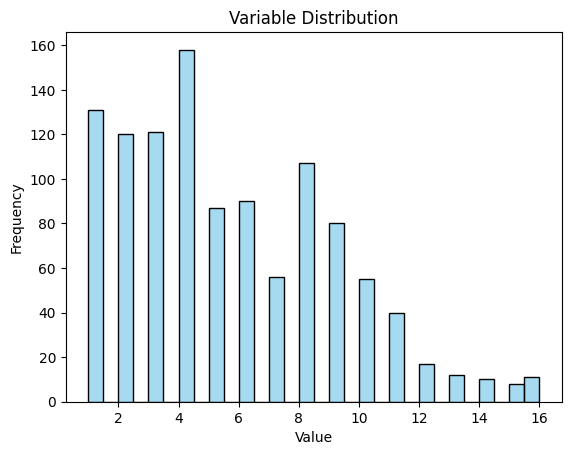

In [35]:
# Getting data from a random account_id
df_pandas = historical_data.filter(col("account_id") == "BR_09607801000194")\
               .orderBy("order_date").toPandas()

# Assuming you have a Series or a DataFrame column
sns.histplot(df_pandas['order_days'], bins=30, color='skyblue')
plt.title("Variable Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [36]:
# Basic statistics
lambda_est = np.mean(df_pandas['order_days'])
mean_val = np.mean(df_pandas['order_days'])
var_val = np.var(df_pandas['order_days'], ddof=1)
n = len(df_pandas['order_days'])

print(f"Basic Statistics:")
print(f"Estimated lambda: {lambda_est:.4f}")
print(f"Mean: {mean_val:.4f}")
print(f"Variance: {var_val:.4f}")
print(f"Variance/Mean Ratio: {var_val/mean_val:.4f}")
print(f"Sample size: {n}\n")

Basic Statistics:
Estimated lambda: 5.5258
Mean: 5.5258
Variance: 12.1842
Variance/Mean Ratio: 2.2050
Sample size: 1103




Considering that order days are discrete and countable events,and we are counting occurrences over a fixed interval (one month),there are 3 possible suitable distributions:

1. **Poisson distribution**:

    $P(X = k) = (λ^{k} * e^{-λ}) / k!$

    Where:
    X = number of order days in a month\
    k = 0, 1, 2, 3, ... (non-negative integers)\
    λ = rate parameter (average number of order days per month)\

2. **Negative Binomial distribution:**\

    $P(X = k) = C(k + r - 1, k) * p^r * (1 - p)^k$\

    where C(n, k) is the binomial coefficient
    Parameters:\
    k: number of failures before the r-th success (k = 0, 1, 2, ...)\
    r: desired number of successes (r > 0)\
    p: probability of success in each trial (0 < p ≤ 1)\

3. **Geometric distribution:**\

  $P(X = k) = (1 - p)^(k - 1) * p$

  Parameters:\
  k: number of trials until the first success (k = 1, 2, 3, ...)\
  p: probability of success in each trial (0 < p ≤ 1)\

For this, we will use the non-parametric Kolmogorov-Smirnov (KS) test, which compares a sample with a known theoretical distribution (goodness-of-fit test), or compares two samples. It checks whether the sample follows the hypothesized distribution.



In [37]:
# Estatísticas básicas
lambda_est = np.mean(df_pandas['order_days'])
mean_val = np.mean(df_pandas['order_days'])
var_val = np.var(df_pandas['order_days'], ddof=1)
n = len(df_pandas['order_days'])

print(f"Estatísticas Básicas:")
print(f"Lambda estimado: {lambda_est:.4f}")
print(f"Média: {mean_val:.4f}")
print(f"Variância: {var_val:.4f}")
print(f"Razão Var/Média: {var_val/mean_val:.4f}")
print(f"Tamanho da amostra: {n}\n")

Estatísticas Básicas:
Lambda estimado: 5.5258
Média: 5.5258
Variância: 12.1842
Razão Var/Média: 2.2050
Tamanho da amostra: 1103



In [38]:
from scipy import stats
from scipy.stats import nbinom, poisson, kstest, geom
from collections import Counter

# Kolmogorov-Smirnov Test for Poisson distribution
lambda_poisson = df_pandas['order_days'].mean()
ks_stat_poisson, ks_p_poisson = kstest(df_pandas['order_days'], cdf='poisson', args=(lambda_poisson,))
print(f"Kolmogorov-Smirnov Test for Poisson: statistic = {ks_stat_poisson:.4f}, p-value = {ks_p_poisson:.4f}")

# Estimating the parameter for the geometric distribution
# p = 1 / mean
p_est = 1 / np.mean(df_pandas['order_days'])

# KS test for geometric distribution
D, p_value = kstest(df_pandas['order_days'], cdf='geom', args=(p_est,))
print(f"KS Statistic (Geometric): {D:.4f}")
print(f"p-value: {p_value:.4f}")

from scipy.stats import nbinom
from scipy.optimize import minimize

data = df_pandas['order_days'].values

# Parameter estimation using maximum likelihood method
mean_val = np.mean(data)
var_val = np.var(data)

# Initial parameters
p0 = mean_val / var_val
r0 = mean_val**2 / (var_val - mean_val)

# Negative log-likelihood for negative binomial
def nbinom_neg_log_likelihood(params):
    r, p = params
    return -np.sum(nbinom.logpmf(data, r, p))

res = minimize(nbinom_neg_log_likelihood, x0=[r0, p0], bounds=[(1e-5, None), (1e-5, 1 - 1e-5)])
r_est, p_est = res.x

# KS test for Negative Binomial
D, p_val = kstest(data, cdf='nbinom', args=(r_est, p_est))
print(f"KS Statistic (Negative Binomial): {D:.4f}")
print(f"p-value: {p_val:.4f}")

Kolmogorov-Smirnov Test for Poisson: statistic = 0.2004, p-value = 0.0000
KS Statistic (Geometric): 0.2230
p-value: 0.0000
KS Statistic (Negative Binomial): 0.1262
p-value: 0.0000


The KS test suggests that the data does not follow the Poisson, Negative Binomial, or Geometric distributions.
However, we can estimate an empirical probability distribution function instead.

It is a distribution built directly from observed data, without assuming any parametric form
(like Poisson, Normal, Geometric, etc). Instead, it represents the observed frequency (or density) of the data.
This approach is adopted because:

- The goodness-of-fit tests (like KS) reject all tested distributions.
- The goal is simulation, sampling, probability calculations, or visualization based on real data.
- The true distribution is complex, truncated, or compound, and not easily modeled by a classical distribution.


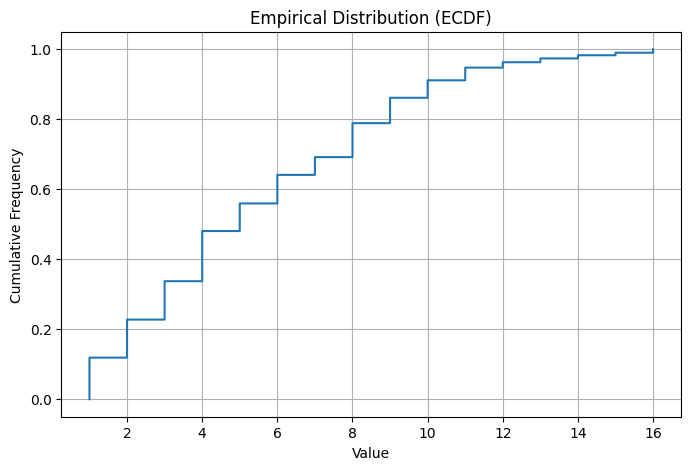

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF

# Assume your data is in a list or array
dados = df_pandas['order_days'].values

ecdf = ECDF(dados)

# Plot ECDF
plt.figure(figsize=(8, 5))
plt.step(ecdf.x, ecdf.y, where='post')
plt.xlabel('Value')
plt.ylabel('Cumulative Frequency')
plt.title('Empirical Distribution (ECDF)')
plt.grid()
plt.show()

## 2.b

Since we are using the empirical distribution, the parameters are the sampled data themselves.
The ECDF is defined as:

$$
\hat{F}(x) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}_{x_i \leq x}
$$

## 2.c

In [40]:
# 2c. Probability of more than 4 days via ECDF
p_leq_4 = ecdf(4)    # ECDF gives P(X <= 4)
p_gt_4_empirical = 1 - p_leq_4
print(f"Empirical probability of more than 4 order days: {p_gt_4_empirical:.4f}")

Empirical probability of more than 4 order days: 0.5195
